In [1]:
import os
import scipy.io
import numpy as np
import pandas as pd
import torch
import random

In [2]:
seed=99

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set your seed
set_seed(seed)

# Function to ensure DataLoader workers are seeded correctly
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

In [3]:
knn_param = 10

In [4]:
#importing python libraries
import numpy as np
import pandas as pd

In [5]:
# import chardet

# with open('Darknet_orig.csv', 'rb') as f:
#     result = chardet.detect(f.read(100000))  # Analyze a portion of the file
#     print(result)


In [6]:
#Reading the dataset: Darknet 2020
df = pd.read_csv('Darknet_orig.csv', encoding='Windows-1252', on_bad_lines='skip')
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24-07-2015 16:09,229,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24-07-2015 16:09,407,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24-07-2015 16:09,431,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24-07-2015 16:09,359,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24-07-2015 16:09,10778451,591,400,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,Audio-Streaming


In [7]:
#A look at all the 85 columns of the dataset
df.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Len

In [8]:
#Getting all the columns with total number of entries in each column and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158616 entries, 0 to 158615
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     158616 non-null  object 
 1   Src IP                      158616 non-null  object 
 2   Src Port                    158616 non-null  int64  
 3   Dst IP                      158616 non-null  object 
 4   Dst Port                    158616 non-null  int64  
 5   Protocol                    158616 non-null  int64  
 6   Timestamp                   158616 non-null  object 
 7   Flow Duration               158616 non-null  int64  
 8   Total Fwd Packet            158616 non-null  int64  
 9   Total Bwd packets           158616 non-null  int64  
 10  Total Length of Fwd Packet  158616 non-null  int64  
 11  Total Length of Bwd Packet  158616 non-null  int64  
 12  Fwd Packet Length Max       158616 non-null  int64  
 13  Fwd Packet Len

In [9]:
# Dropping the specified columns
df_filtered = df.drop(['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label', 'Label.1'], axis=1)

# Calculating the correlation matrix
corr = df_filtered.corr()

# Displaying the first few rows of the correlation matrix
corr.head()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Src Port,1.000000,-0.301786,-0.057655,0.082978,-0.032959,-0.012450,-0.018305,-0.007205,0.087506,-0.064714,...,-0.026095,0.102185,NaN,NaN,NaN,NaN,0.122216,0.070426,0.127904,0.072489
Dst Port,-0.301786,1.000000,-0.307383,0.021646,0.021950,0.014518,0.005196,0.010623,-0.012535,-0.175790,...,0.015308,0.243330,NaN,NaN,NaN,NaN,0.009292,-0.014043,0.003425,0.010698
Protocol,-0.057655,-0.307383,1.000000,-0.258877,-0.032533,-0.024783,-0.021150,-0.019740,-0.198002,0.581563,...,-0.021288,-0.879764,NaN,NaN,NaN,NaN,-0.187675,-0.150728,-0.202803,-0.091176
Flow Duration,0.082978,0.021646,-0.258877,1.000000,0.137117,0.097069,0.068921,0.054940,0.346994,-0.076752,...,0.139767,0.235576,NaN,NaN,NaN,NaN,0.497905,0.117312,0.496687,0.395740
Total Fwd Packet,-0.032959,0.021950,-0.032533,0.137117,1.000000,0.744999,0.457321,0.635565,0.123680,-0.020180,...,0.698783,0.028681,NaN,NaN,NaN,NaN,0.063264,-0.017387,0.059042,0.070571


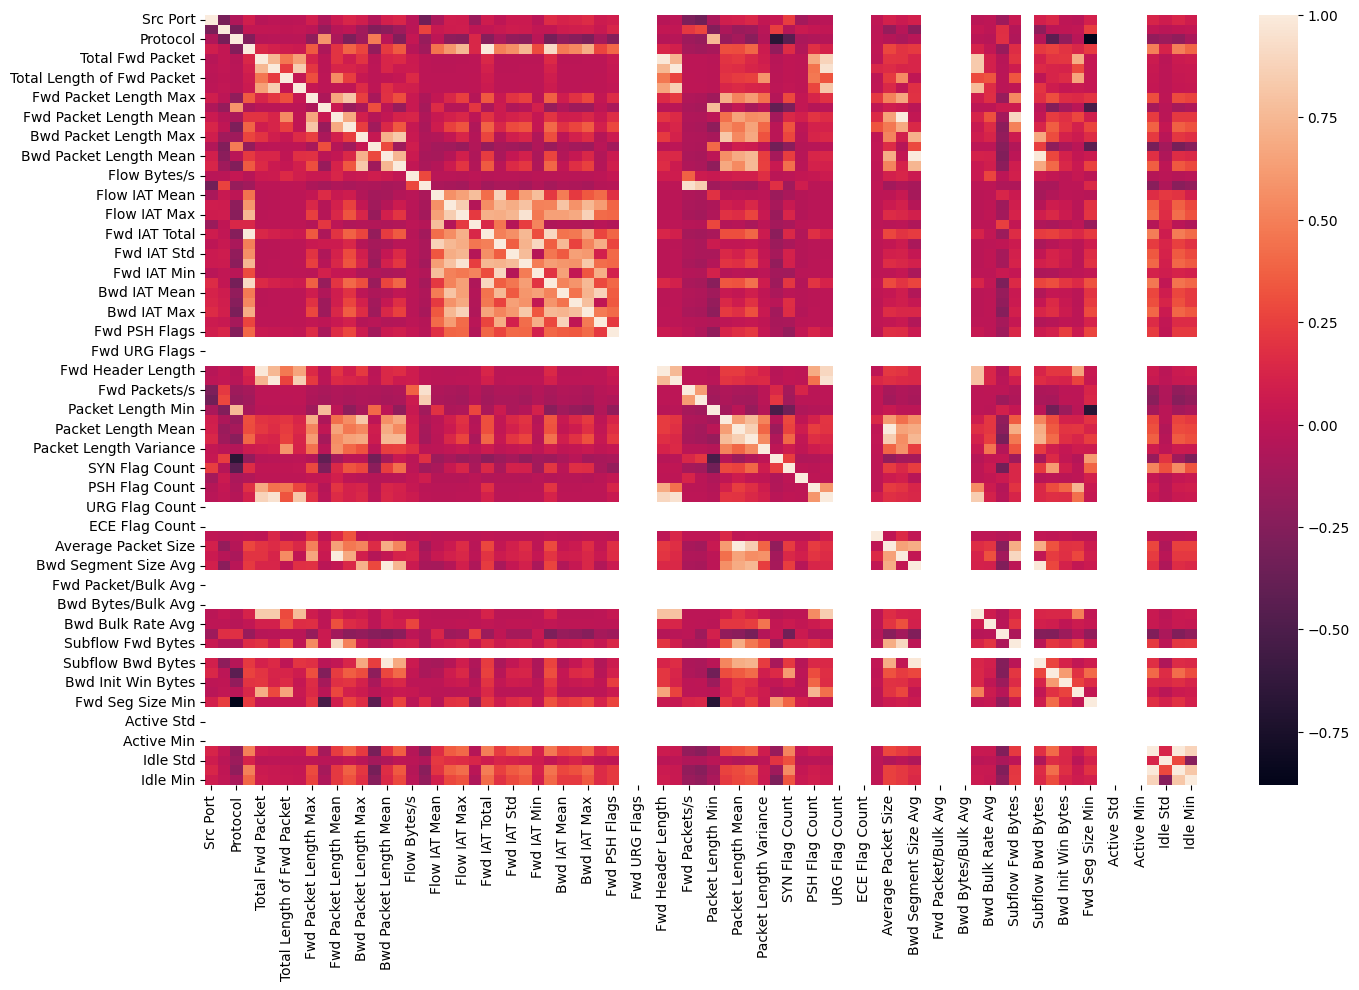

In [10]:
#Correlation matrix in the form of heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))

sns.heatmap(corr)
plt.show()

In [11]:
df.dropna() #dropping null values

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24-07-2015 16:09,229,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24-07-2015 16:09,407,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24-07-2015 16:09,431,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24-07-2015 16:09,359,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24-07-2015 16:09,10778451,591,400,...,0,0,0,0,1.437760e+15,3.117718e+06,1.437760e+15,1.437760e+15,Non-Tor,Audio-Streaming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158611,10.8.8.246-224.0.0.252-55219-5355-17,10.8.8.246,55219,224.0.0.252,5355,17,22-05-2015 13:55,411806,2,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
158612,10.8.8.246-224.0.0.252-64207-5355-17,10.8.8.246,64207,224.0.0.252,5355,17,22-05-2015 14:09,411574,2,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
158613,10.8.8.246-224.0.0.252-61115-5355-17,10.8.8.246,61115,224.0.0.252,5355,17,22-05-2015 14:19,422299,2,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
158614,10.8.8.246-224.0.0.252-64790-5355-17,10.8.8.246,64790,224.0.0.252,5355,17,22-05-2015 14:29,411855,2,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP


In [12]:
df.isnull().sum().head() #to check the number of null values in each column

Flow ID     0
Src IP      0
Src Port    0
Dst IP      0
Dst Port    0
dtype: int64

In [13]:
df['Label'].value_counts()  #to check the number of classes in Label

Label
Non-Tor    110442
NonVPN      23863
VPN         22919
Tor          1392
Name: count, dtype: int64

In [14]:
df['Label.1'].value_counts() #to check the number of classes in Label

Label.1
P2P                48520
Browsing           46457
Audio-Streaming    21350
Chat               11629
File-Transfer      11182
Video-Streaming     9767
Email               6145
VOIP                3566
Name: count, dtype: int64

In [15]:
#splitting the Src IP into octets,getting first two octets
newIP = []
for value in df['Src IP']:
    IP = value.split(".")
    octet1= IP[0]
    octet2= IP[1]

    newIP.append(float(octet1 + '.' + octet2))

df1 = pd.DataFrame(newIP)  #a new dataframe with the above obtained series
df['Src IP'] = df1  #replacing column Src IP with df1
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152,57158,216.58.220.99,443,6,24-07-2015 16:09,229,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
1,10.152.152.11-216.58.220.99-57159-443-6,10.152,57159,216.58.220.99,443,6,24-07-2015 16:09,407,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
2,10.152.152.11-216.58.220.99-57160-443-6,10.152,57160,216.58.220.99,443,6,24-07-2015 16:09,431,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
3,10.152.152.11-74.125.136.120-49134-443-6,10.152,49134,74.125.136.120,443,6,24-07-2015 16:09,359,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152,34697,173.194.65.127,19305,6,24-07-2015 16:09,10778451,591,400,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,Audio-Streaming


In [16]:
newIP1 = [] #splitting the Dst IP into octets,getting first two octets
for value in df['Dst IP']:
    IP = value.split(".")
    octet1= IP[0]
    octet2= IP[1]
    
    newIP1.append(float(octet1 + '.' + octet2))
df2 = pd.DataFrame(newIP1)
df['Dst IP'] = df2
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152,57158,216.580,443,6,24-07-2015 16:09,229,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
1,10.152.152.11-216.58.220.99-57159-443-6,10.152,57159,216.580,443,6,24-07-2015 16:09,407,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
2,10.152.152.11-216.58.220.99-57160-443-6,10.152,57160,216.580,443,6,24-07-2015 16:09,431,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
3,10.152.152.11-74.125.136.120-49134-443-6,10.152,49134,74.125,443,6,24-07-2015 16:09,359,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152,34697,173.194,19305,6,24-07-2015 16:09,10778451,591,400,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,Audio-Streaming


In [17]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
Le = LabelEncoder()

# Fit the encoder for 'Label' and get the mapping
df['Label'] = Le.fit_transform(df['Label'])
label_mapping = dict(zip(Le.classes_, Le.transform(Le.classes_)))
print("Label mapping:", label_mapping)

# Fit the encoder for 'Label.1' and get the mapping
df['Label.1'] = Le.fit_transform(df['Label.1'])
label_1_mapping = dict(zip(Le.classes_, Le.transform(Le.classes_)))
print("Label.1 mapping:", label_1_mapping)


Label mapping: {'Non-Tor': 0, 'NonVPN': 1, 'Tor': 2, 'VPN': 3}
Label.1 mapping: {'Audio-Streaming': 0, 'Browsing': 1, 'Chat': 2, 'Email': 3, 'File-Transfer': 4, 'P2P': 5, 'VOIP': 6, 'Video-Streaming': 7}


In [18]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152,57158,216.580,443,6,24-07-2015 16:09,229,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
1,10.152.152.11-216.58.220.99-57159-443-6,10.152,57159,216.580,443,6,24-07-2015 16:09,407,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
2,10.152.152.11-216.58.220.99-57160-443-6,10.152,57160,216.580,443,6,24-07-2015 16:09,431,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
3,10.152.152.11-74.125.136.120-49134-443-6,10.152,49134,74.125,443,6,24-07-2015 16:09,359,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152,34697,173.194,19305,6,24-07-2015 16:09,10778451,591,400,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,0,0


In [19]:
df3=df.drop(['Flow ID', 'Timestamp'], axis = 1) #dropping the unnecessary columns
df3.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152,57158,216.580,443,6,229,1,1,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
1,10.152,57159,216.580,443,6,407,1,1,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
2,10.152,57160,216.580,443,6,431,1,1,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
3,10.152,49134,74.125,443,6,359,1,1,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
4,10.152,34697,173.194,19305,6,10778451,591,400,64530,6659,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,0,0


In [20]:
# # Create a new dataframe with 'label' and 'Label.1' columns
# df_labels = df3[['Label', 'Label.1']]

# # Create a new dataframe without 'label' and 'Label.1' columns
# df4 = df3.drop(['Label', 'Label.1'], axis=1)


In [21]:
df3['Idle Mean']=df3['Idle Mean']/1e15
df3['Idle Max']=df3['Idle Max']/1e15
df3['Idle Min']=df3['Idle Min']/1e15
df3['Idle Std']=df3['Idle Std']/1e7

In [22]:
df3.isnull().values.any() 

True

In [23]:
df3.fillna(np.nan).head(5) 

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152,57158,216.580,443,6,229,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
1,10.152,57159,216.580,443,6,407,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
2,10.152,57160,216.580,443,6,431,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
3,10.152,49134,74.125,443,6,359,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
4,10.152,34697,173.194,19305,6,10778451,591,400,64530,6659,...,0,0,0,0,1.43776,0.311772,1.43776,1.43776,0,0


In [24]:
# Replacing infinite with nan 
df3.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
df3.dropna(inplace=True) 

In [25]:
df3.isnull().values.any() 

False

In [26]:
df3.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152,57158,216.580,443,6,229,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
1,10.152,57159,216.580,443,6,407,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
2,10.152,57160,216.580,443,6,431,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
3,10.152,49134,74.125,443,6,359,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
4,10.152,34697,173.194,19305,6,10778451,591,400,64530,6659,...,0,0,0,0,1.43776,0.311772,1.43776,1.43776,0,0


In [27]:
# Get unique labels and their frequency in the 'Label' column
label_counts = df3['Label'].value_counts()

# Print the unique labels and their frequency
print("Unique labels and their frequency in 'Label' column:")
print(label_counts)


Unique labels and their frequency in 'Label' column:
Label
0    110394
1     23861
3     22919
2      1392
Name: count, dtype: int64


In [28]:
# Replace 0 and 1 with 0, and 2 and 3 with 1 to convert to binary classification
df3['Label'] = df3['Label'].replace({0: 0, 1: 0, 2: 1, 3: 1})

# Verify the replacement by printing the updated label counts
updated_label_counts = df3['Label'].value_counts()

print("Updated labels and their frequency after conversion to binary classification:")
print(updated_label_counts)

Updated labels and their frequency after conversion to binary classification:
Label
0    134255
1     24311
Name: count, dtype: int64


In [29]:
df3.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152,57158,216.580,443,6,229,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
1,10.152,57159,216.580,443,6,407,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
2,10.152,57160,216.580,443,6,431,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
3,10.152,49134,74.125,443,6,359,1,1,0,0,...,0,0,0,0,0.00000,0.000000,0.00000,0.00000,0,0
4,10.152,34697,173.194,19305,6,10778451,591,400,64530,6659,...,0,0,0,0,1.43776,0.311772,1.43776,1.43776,0,0


In [30]:
import pandas as pd

# Assuming df3 has a 'Label' column with 0 and 1 as the two classes
# Step 1: Separate the majority and minority classes
df_majority = df3[df3['Label'] == 0]
df_minority = df3[df3['Label'] == 1]

# Step 2: Undersample the majority class
# Get the number of samples in the minority class
minority_count = len(df_minority)

# Randomly sample from the majority class to match the minority class size
df_majority_undersampled = df_majority.sample(n=minority_count, random_state=99)

# Step 3: Combine the undersampled majority class with the minority class
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the DataFrame to mix the rows
df3 = df_balanced.sample(frac=1, random_state=99).reset_index(drop=True)

# Check the new label distribution
print(df3['Label'].value_counts())


Label
0    24311
1    24311
Name: count, dtype: int64


In [31]:
# Initialize empty lists for graphs (X_2) and labels (y_2)
X_2 = []
y_2 = []

# Iterate over each row of df3
for index, row in df3.iterrows():
    # Step 1: Extract the label for the current row (flow) and append it to y_2
    y_2.append(int(row['Label']))  # Assuming 'Label' column contains the class label

    # Step 2: Drop unnecessary columns (Timestamp, Label, Label.1 if present) to keep only the features
    df_temp = row.drop(['Label', 'Label.1'], errors='ignore')  # Use 'errors=ignore' in case columns don't exist
    
    # Step 3: Append the feature values (row without 'Label' and 'Timestamp') to X_2
    X_2.append(np.array(df_temp))

print(X_2[0])
print(y_2[0])


[1.01520000e+01 4.72080000e+04 1.01520000e+01 5.30000000e+01
 1.70000000e+01 3.79182000e+05 1.00000000e+00 1.00000000e+00
 3.60000000e+01 5.20000000e+01 3.60000000e+01 3.60000000e+01
 3.60000000e+01 0.00000000e+00 5.20000000e+01 5.20000000e+01
 5.20000000e+01 0.00000000e+00 2.32078527e+02 5.27451198e+00
 3.79182000e+05 0.00000000e+00 3.79182000e+05 3.79182000e+05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.00000000e+00 8.00000000e+00
 2.63725599e+00 2.63725599e+00 3.60000000e+01 5.20000000e+01
 4.13333333e+01 9.23760431e+00 8.53333333e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 6.20000000e+01 3.60000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [32]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Convert X_2 (list of arrays) into a 2D matrix
X_2_matrix = np.array(X_2)  # This keeps it as a 2D array (matrix), no extra dimensions

# Step 2: Initialize the StandardScaler and fit it to the data
scaler = StandardScaler()
X_2_scaled = scaler.fit_transform(X_2_matrix)

# Now X_2_scaled is a 2D matrix with standardized features for each flow
print(X_2_scaled.shape)  # Shape of the scaled matrix
print(X_2_scaled[0])     # Check the first flow's scaled feature array


(48622, 81)
[-0.43134889  0.52169526 -1.52963392 -0.65121668  0.95761323 -0.49690196
 -0.0898498  -0.07177834 -0.06860531 -0.03547355 -0.30225453  0.48908866
 -0.19421466 -0.40625905 -0.31003947 -0.26554266 -0.41729531 -0.31281415
 -0.17623131 -0.20133552 -0.2588887  -0.36077599 -0.42164782 -0.06199151
 -0.4931811  -0.31414763 -0.31848604 -0.42741753 -0.21502826 -0.44384472
 -0.2653443  -0.2828854  -0.37328749 -0.16649737 -0.32812127  0.
  0.          0.         -0.08763633 -0.07061818 -0.18243754 -0.19171351
  0.74177411 -0.35246687 -0.38399944 -0.61350335 -0.11953315 -0.66082918
 -0.44960105 -0.144441   -0.09979063 -0.07606287  0.          0.
  0.          0.40526466 -0.38456851 -0.19421466 -0.41729531  0.
  0.          0.          0.         -0.0782891  -0.04335927 -0.49976218
 -0.19383296  0.         -0.38609414 -0.43349789 -0.23579465 -0.08299949
 -0.84926335  0.          0.          0.          0.         -0.83430238
 -0.23982589 -0.84284868 -0.73082098]


In [33]:
y_2= np.array(y_2)
y_2.shape

(48622,)

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

# Initialize lists to store feature matrices and adjacency matrices
feature_matrices = []
adjacency_matrices = []

# Step 1: Iterate over each flow (row in X_2_scaled)
for i in range(X_2_scaled.shape[0]):
    # Extract the feature vector for the current flow
    flow_features = X_2_scaled[i].reshape(-1, 1)  # Reshape to make it 2D for cosine similarity
    
    # Step 2: Calculate pairwise cosine similarity between features
    similarity_matrix = cosine_similarity(flow_features)
    
    # Step 3: Create adjacency matrix based on similarity threshold (you can tune this threshold)
    similarity_threshold = 0.8  # You can adjust this threshold
    adjacency_matrix = (similarity_matrix > similarity_threshold).astype(int)  # Convert to binary adjacency matrix
    
    # Step 4: Store the feature matrix and adjacency matrix
    feature_matrices.append(X_2_scaled[i])  # Keep the feature vector for each flow
    adjacency_matrices.append(adjacency_matrix)  # Store the adjacency matrix

# Convert feature_matrices to a NumPy array for consistency
feature_matrices = np.array(feature_matrices)

# Convert adjacency_matrices to a NumPy array if needed
adjacency_matrices = np.array(adjacency_matrices)

# Output the first adjacency and feature matrix for verification
print("Feature matrix for the first flow:", feature_matrices[0])
print("Adjacency matrix for the first flow:", adjacency_matrices[0])

Feature matrix for the first flow: [-0.43134889  0.52169526 -1.52963392 -0.65121668  0.95761323 -0.49690196
 -0.0898498  -0.07177834 -0.06860531 -0.03547355 -0.30225453  0.48908866
 -0.19421466 -0.40625905 -0.31003947 -0.26554266 -0.41729531 -0.31281415
 -0.17623131 -0.20133552 -0.2588887  -0.36077599 -0.42164782 -0.06199151
 -0.4931811  -0.31414763 -0.31848604 -0.42741753 -0.21502826 -0.44384472
 -0.2653443  -0.2828854  -0.37328749 -0.16649737 -0.32812127  0.
  0.          0.         -0.08763633 -0.07061818 -0.18243754 -0.19171351
  0.74177411 -0.35246687 -0.38399944 -0.61350335 -0.11953315 -0.66082918
 -0.44960105 -0.144441   -0.09979063 -0.07606287  0.          0.
  0.          0.40526466 -0.38456851 -0.19421466 -0.41729531  0.
  0.          0.          0.         -0.0782891  -0.04335927 -0.49976218
 -0.19383296  0.         -0.38609414 -0.43349789 -0.23579465 -0.08299949
 -0.84926335  0.          0.          0.          0.         -0.83430238
 -0.23982589 -0.84284868 -0.73082098]
Ad

In [35]:
print(feature_matrices.shape)
print(adjacency_matrices.shape)

(48622, 81)
(48622, 81, 81)


In [36]:
# Reshape to (num_samples, num_nodes, 1)
expanded_matrix = feature_matrices[:, :, np.newaxis]  # Shape is (num_samples, num_nodes, 1)

# Create the (num_samples, num_nodes, num_nodes) matrix
feature_matrices = np.matmul(expanded_matrix, expanded_matrix.transpose(0, 2, 1))  # Shape is (num_samples, num_nodes, num_nodes)
print(feature_matrices.shape)

(48622, 81, 81)


In [37]:
feature_matrices[0]

array([[ 0.18606187, -0.22503267,  0.65980589, ...,  0.10344863,
         0.36356185,  0.31523882],
       [-0.22503267,  0.27216595, -0.79800277, ..., -0.12511603,
        -0.43971017, -0.38126584],
       [ 0.65980589, -0.79800277,  2.33977992, ...,  0.36684582,
         1.28924994,  1.11788856],
       ...,
       [ 0.10344863, -0.12511603,  0.36684582, ...,  0.05751646,
         0.20213694,  0.17526979],
       [ 0.36356185, -0.43971017,  1.28924994, ...,  0.20213694,
         0.71039391,  0.6159715 ],
       [ 0.31523882, -0.38126584,  1.11788856, ...,  0.17526979,
         0.6159715 ,  0.5340993 ]])

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, global_mean_pool, GCNConv
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from torch_geometric.data import InMemoryDataset, Data

def to_tensor(X_featgraph, X_adjgraph, Y):
    datalist = []
    
    for i in range(len(Y)):
        ty = Y[i]

        y = torch.tensor([ty]).long()

        adjacency = X_adjgraph[i]
        feature = X_featgraph[i]

        x = torch.from_numpy(feature).float()
        adj= adjacency
        adj = torch.from_numpy(adj).float()
        edge_index, edge_attr = dense_to_sparse(adj)
        
        datalist.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))

    return datalist

In [39]:
data2 = to_tensor(feature_matrices, adjacency_matrices, y_2)

In [40]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    """GCN model with batch normalization"""

    def __init__(self,
                 num_features,
                 num_classes,
                 dropout=.4):
        super(GCN, self).__init__()

        self.p = dropout

        # Define GCN layers
        self.conv1 = ChebConv(int(num_features), 128, K=3, normalization='sym')
        self.conv2 = ChebConv(128, 64, K=3, normalization='sym')
        self.conv3 = ChebConv(64, 32, K=3, normalization='sym')

        # Define batch normalization layers
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.bn3 = torch.nn.BatchNorm1d(32)

        # Define the final fully connected layer
        self.lin1 = torch.nn.Linear(32, int(num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        # GCN layer 1 with BatchNorm and ReLU
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = func.relu(x)
        x = func.dropout(x, p=self.p, training=self.training)

        # GCN layer 2 with BatchNorm and ReLU
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = func.relu(x)
        x = func.dropout(x, p=self.p, training=self.training)

        # GCN layer 3 with BatchNorm and ReLU
        x = self.conv3(x, edge_index, edge_attr)
        x = self.bn3(x)
        x = func.relu(x)

        # Global mean pooling and final linear layer
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        
        return x


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score

def GCN_train(loader):
    model.train()
    
    loss_all = 0
    correct = 0
    total = 0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        output = model(data)
        # print(output.shape, data.y.shape)
        loss = func.cross_entropy(output, data.y)
        loss.backward()
        optimizer.step()
        loss_all += data.num_graphs * loss.item()
        _, pred = output.max(dim=1)
        correct += pred.eq(data.y).sum().item()  # Count number of correct predictions
        total += data.num_graphs  # Assuming each graph has one label (adjust if needed)

    # Calculate average loss and accuracy
    avg_loss = loss_all / total
    accuracy = correct / total

    return avg_loss, accuracy


def GCN_test(loader):
    model.eval()

    pred = []
    scores = []
    label = []
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        loss = func.cross_entropy(output, data.y)
        loss_all += data.num_graphs * loss.item()
        
        # Collect predictions and true labels
        scores.append(func.softmax(output, dim=1)[:, 1])  # Probabilities for the positive class
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])  # Predicted class
        label.append(data.y)

    # Concatenate the predictions, scores, and true labels
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()      # Predicted labels
    y_scores = torch.cat(scores, dim=0).cpu().detach().numpy()  # Predicted scores (probabilities for positive class)
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()     # True labels

    # Calculate accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    # Calculate F1-score
    epoch_f1 = f1_score(y_true, y_pred)

    # Calculate Recall
    epoch_recall = recall_score(y_true, y_pred)
    
    # Calculate Precision
    epoch_precision = precision_score(y_true, y_pred)

    # Calculate AUC (for binary classification)
    epoch_auc = roc_auc_score(y_true, y_scores)

    return epoch_acc, epoch_f1, epoch_precision, epoch_recall, epoch_auc, loss_all / 100


In [43]:
skf2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
eval_metrics2 = np.zeros((skf2.n_splits, 5))

In [44]:
for n_fold, (train, test) in enumerate(skf2.split(data2, y_2)):
    model = GCN(num_features=81, num_classes=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    
    train_dataset = [data2[i] for i in train]
    test_dataset = [data2[i] for i in test]
    train_labels = np.array([y_2[i] for i in train])  # Correctly extract train labels
    test_labels = np.array([y_2[i] for i in test])    # Correctly extract test labels
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker, generator=g)

    best_acc=0
    for epoch in range(50):
        t_loss, t_acc = GCN_train(train_loader)
        test_acc, test_f1, test_prec, test_recall, test_auc, test_loss = GCN_test(test_loader)
        
        if best_acc < test_acc:
            best_acc = test_acc
            eval_metrics2[n_fold, 0] = best_acc
            eval_metrics2[n_fold, 1] = test_f1
            eval_metrics2[n_fold, 2] = test_prec
            eval_metrics2[n_fold, 3] = test_recall
            eval_metrics2[n_fold, 4] = test_auc

        print('CV: {:03d}, Epoch: {:03d}, Train LOSS: {:.5f}, Train ACC: {:.5f}, Test ACC: {:.5f}, Test F1: {:.5f}, Test PREC: {:.5f}, Test Recall: {:.5f}, Test AUC: {:.5f}'.format(n_fold +1, epoch + 1, t_loss, t_acc, test_acc, test_f1, test_prec, test_recall, test_auc))
        

CV: 001, Epoch: 001, Train LOSS: 0.14457, Train ACC: 0.94934, Test ACC: 0.93420, Test F1: 0.93206, Test PREC: 0.96314, Test Recall: 0.90292, Test AUC: 0.97150
CV: 001, Epoch: 002, Train LOSS: 0.08851, Train ACC: 0.97146, Test ACC: 0.97594, Test F1: 0.97586, Test PREC: 0.97889, Test Recall: 0.97285, Test AUC: 0.99426
CV: 001, Epoch: 003, Train LOSS: 0.08222, Train ACC: 0.97281, Test ACC: 0.97080, Test F1: 0.97098, Test PREC: 0.96468, Test Recall: 0.97738, Test AUC: 0.99332
CV: 001, Epoch: 004, Train LOSS: 0.07571, Train ACC: 0.97534, Test ACC: 0.98005, Test F1: 0.97982, Test PREC: 0.99116, Test Recall: 0.96874, Test AUC: 0.99548
CV: 001, Epoch: 005, Train LOSS: 0.07581, Train ACC: 0.97628, Test ACC: 0.98437, Test F1: 0.98425, Test PREC: 0.99206, Test Recall: 0.97655, Test AUC: 0.99680
CV: 001, Epoch: 006, Train LOSS: 0.07536, Train ACC: 0.97667, Test ACC: 0.85770, Test F1: 0.86594, Test PREC: 0.81838, Test Recall: 0.91937, Test AUC: 0.94346
CV: 001, Epoch: 007, Train LOSS: 0.07131, Trai

In [45]:
eval_df2 = pd.DataFrame(eval_metrics2)
eval_df2.columns = ['ACC', 'F1', 'Prec', 'Recall', 'AUC']
eval_df2.index = ['Fold_%02i' % (i + 1) for i in range(skf2.n_splits)]
print(eval_df2)
print('Average Accuracy: %.4f±%.4f' % (eval_metrics2[:, 0].mean(), eval_metrics2[:, 0].std()))
print('Average F1: %.4f±%.4f' % (eval_metrics2[:, 1].mean(), eval_metrics2[:, 1].std()))
print('Average Precision: %.4f±%.4f' % (eval_metrics2[:, 2].mean(), eval_metrics2[:, 2].std()))
print('Average Recall: %.4f±%.4f' % (eval_metrics2[:, 3].mean(), eval_metrics2[:, 3].std()))
print('Average AUC: %.4f±%.4f' % (eval_metrics2[:, 4].mean(), eval_metrics2[:, 4].std()))

              ACC        F1      Prec    Recall       AUC
Fold_01  0.989307  0.989247  0.994595  0.983957  0.997006
Fold_02  0.984577  0.984520  0.988396  0.980674  0.997466
Fold_03  0.987865  0.987863  0.988066  0.987659  0.996836
Fold_04  0.988688  0.988685  0.988889  0.988482  0.996522
Fold_05  0.985191  0.985136  0.988811  0.981489  0.996554
Fold_06  0.983752  0.983674  0.988372  0.979021  0.995763
Fold_07  0.986014  0.985968  0.989234  0.982723  0.997220
Fold_08  0.985191  0.985099  0.991254  0.979021  0.997629
Fold_09  0.986837  0.986837  0.986837  0.986837  0.996859
Fold_10  0.987865  0.987848  0.989274  0.986425  0.997500
Average Accuracy: 0.9865±0.0018
Average F1: 0.9865±0.0018
Average Precision: 0.9894±0.0020
Average Recall: 0.9836±0.0034
Average AUC: 0.9969±0.0005


In [46]:
model

GCN(
  (conv1): ChebConv(81, 128, K=3, normalization=sym)
  (conv2): ChebConv(128, 64, K=3, normalization=sym)
  (conv3): ChebConv(64, 32, K=3, normalization=sym)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
)

In [47]:
import torch

def compute_grad_cam(model, data, target_class):
    """
    Compute the Grad-CAM values for a given sample and target class.
    Args:
    - model: The trained GCN model.
    - data: The input data (PyG Data object).
    - target_class: The class for which to compute the Grad-CAM (e.g., 1 for recurrent MDD).
    
    Returns:
    - contributions: The Grad-CAM contributions for each node (brain region).
    """
    # Set the model to evaluation mode
    model.eval()

    # Enable gradients for the input node feature matrix (V)
    data.x.requires_grad = True

    # Forward pass to get the model output
    output = model(data)
    
    # Select the score corresponding to the target class
    target_score = output[:, target_class].sum()

    # Backward pass: Compute gradients with respect to the input features (V)
    model.zero_grad()
    target_score.backward(retain_graph=True)
    
    # Get the gradients of the input features (V) w.r.t. the target score
    gradients = data.x.grad  # This contains the gradients of the input V

    # Check if gradients are None
    if gradients is None:
        raise ValueError("Gradients were not computed. Ensure that 'requires_grad=True' for the input tensor.")

    V = data.x  # Input feature matrix

    # Compute Grad-CAM values by multiplying gradients by input feature values
    grad_cam = V * gradients  # Element-wise product

    # To compute the contribution of each brain region (node), take the average of Grad-CAM over time (rows)
    contributions = grad_cam.mean(dim=0)  # Average over the time axis (row-wise)

    return contributions


In [48]:
# Initialize an empty list to store contributions for all test samples
all_contributions = []

test_loader2 = DataLoader(test_dataset, batch_size=1, shuffle=False, worker_init_fn=seed_worker, generator=g)

# Iterate over each sample in the test loader
for data in test_loader2:
    data = data.to(device)
    
    # Compute the Grad-CAM contribution for each sample (for the target class, e.g., class 1 for recurrent MDD)
    contributions = compute_grad_cam(model, data, target_class=1)  # Assuming target_class=1 for recurrent MDD
    
    # Convert the contributions tensor to numpy and append it to the list
    all_contributions.append(contributions.cpu().detach().numpy())

# Convert the list of all contributions to a numpy array (shape: [num_samples, num_brain_regions])
all_contributions = np.array(all_contributions)
print("shappe = ", all_contributions.shape)

# Step 1: Calculate the mean contribution across all samples (mean over the first axis)
mean_contributions = np.mean(all_contributions, axis=0)
print("shappe after mean = ", mean_contributions.shape)

# Step 2: Sort the mean contributions in descending order and get the sorted indices
sorted_indices = np.argsort(mean_contributions)[::-1]

# Print the sorted contributions and corresponding indices (brain regions)
print("Sorted Contributions: ", mean_contributions[sorted_indices])
print("Sorted Indices: ", sorted_indices)


shappe =  (4862, 81)
shappe after mean =  (81,)
Sorted Contributions:  [ 7.47584458e-03  6.87579450e-04  3.32705124e-04  2.57468171e-04
  2.53730774e-04  2.45240197e-04  2.43012371e-04  1.73991240e-04
  1.69135688e-04  1.66187892e-04  1.36946925e-04  1.31430992e-04
  1.09655091e-04  1.07108397e-04  8.50721408e-05  8.40475986e-05
  7.92671563e-05  6.42685845e-05  5.08850244e-05  1.75957739e-05
  1.60051713e-05  1.41758992e-05  1.36410863e-05  9.63101502e-06
  4.93893640e-06  4.20593460e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.65848813e-06 -9.04690205e-06 -9.13394979e-06
 -1.26515861e-05 -2.21982809e-05 -2.87282492e-05 -3.53269206e-05
 -4.49870786e-05 -5.13262203e-05 -5.93490404e-05 -6.84862243e-05
 -7.71933919e-05 -8.10480997e-05 -8.29515047e-05 -8.33463346e-05
 -9.52247356e-05 -1

In [49]:
# Get the column headers of df3
headers = df3.columns

# Extract the headers corresponding to the sorted indices
sorted_headers = headers[sorted_indices]

# Convert to list for easy readability (if needed)
sorted_headers_list = sorted_headers.tolist()

# Print the sorted headers
print("Sorted Headers:", sorted_headers_list)

Sorted Headers: ['Fwd Seg Size Min', 'Bwd Init Win Bytes', 'Idle Mean', 'Idle Max', 'FWD Init Win Bytes', 'Flow Duration', 'Bwd Packet Length Max', 'RST Flag Count', 'Idle Min', 'Packet Length Max', 'Bwd Packet Length Min', 'Bwd Header Length', 'Fwd Packet Length Min', 'Fwd IAT Total', 'Fwd Header Length', 'Down/Up Ratio', 'Bwd IAT Std', 'Bwd IAT Min', 'Packet Length Variance', 'Fwd IAT Min', 'Flow Bytes/s', 'PSH Flag Count', 'ACK Flag Count', 'Total Length of Fwd Packet', 'Fwd Packets/s', 'Flow IAT Mean', 'Active Min', 'Active Std', 'Active Max', 'Fwd URG Flags', 'ECE Flag Count', 'URG Flag Count', 'Active Mean', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Bulk Rate Avg', 'Subflow Bwd Packets', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Bwd Bytes/Bulk Avg', 'CWE Flag Count', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Total Bwd packets', 'Bwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Total Length of Bwd Packet', 'Fwd Act Data Pkts', 'Total Fwd Packet', 'Fwd IAT Std', 'Src Port', 